In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Linear Autoencoder as PCA

In [4]:
# Building a 3d dataset

In [5]:
import numpy.random as rnd

In [6]:
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

In [7]:
angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5

In [8]:
data = np.empty((m, 3))

In [9]:
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()

In [12]:
X_train = scaler.fit_transform(data[:100])

In [13]:
X_test = scaler.transform(data[100:])

In [14]:
tf.reset_default_graph()

In [15]:
n_inputs = 3
n_hidden = 2  
n_outputs = n_inputs

In [16]:
learning_rate = 0.01

In [17]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [18]:
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

In [19]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [20]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [21]:
init = tf.global_variables_initializer()

In [22]:
n_iterations = 1000
codings = hidden

In [23]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

Text(0,0.5,'$d_2$')

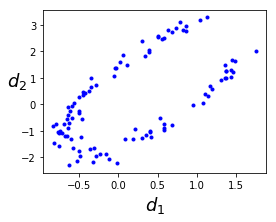

In [24]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$d_1$", fontsize=18)
plt.ylabel("$d_2$", fontsize=18, rotation=0)

# Stacked Autoencoders

In [25]:
tf.reset_default_graph()

In [26]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [27]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [28]:
learning_rate = 0.01
l2_reg = 0.0001

In [29]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [30]:
he_init = tf.contrib.layers.variance_scaling_initializer()

In [31]:
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

In [32]:
from functools import partial

In [33]:
configured_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

In [34]:
hidden1 = configured_dense_layer(X, n_hidden1)
hidden2 = configured_dense_layer(hidden1, n_hidden2)
hidden3 = configured_dense_layer(hidden2, n_hidden3)
outputs = configured_dense_layer(hidden3, n_outputs, activation=None)

In [35]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [36]:
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

In [37]:
loss = tf.add_n([reconstruction_loss] + reg_losses)

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [39]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
n_epochs = 5
batch_size = 150

In [43]:
import sys

In [44]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "./my_model_all_layers.ckpt")

0 Train MSE: 0.027040182
1 Train MSE: 0.013215956
2 Train MSE: 0.010909567
3 Train MSE: 0.010289508
4 Train MSE: 0.0104272235


# Tied weights of encoder and decoder

In [45]:
tf.reset_default_graph()

In [46]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  
n_hidden3 = n_hidden1
n_outputs = n_inputs

In [47]:
learning_rate = 0.01
l2_reg = 0.0005

In [48]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

In [49]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [50]:
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

In [52]:
weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  
weights4 = tf.transpose(weights1, name="weights4")  

In [53]:
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

In [54]:
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

In [55]:
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

In [56]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [57]:
init = tf.global_variables_initializer()

In [58]:
saver = tf.train.Saver()

In [59]:
n_epochs = 5
batch_size = 150

In [60]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.01788037
1 Train MSE: 0.015834222
2 Train MSE: 0.016765831
3 Train MSE: 0.015495255
4 Train MSE: 0.01766818


In [64]:
n_test_digits = 2

In [65]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_tying_weights.ckpt")
    X_test = mnist.test.images[:n_test_digits]
    outputs_val = outputs.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


In [67]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

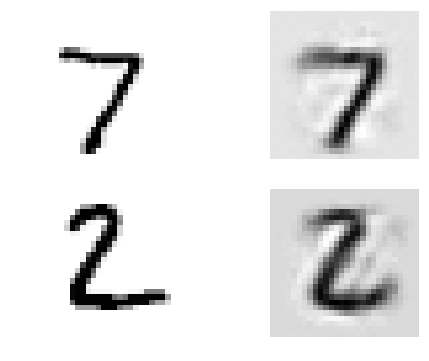

In [68]:
fig = plt.figure(figsize=(8, 3 * n_test_digits))
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])